## Training a GPT-2 model on DNA

[Theis et al. (2016)](https://arxiv.org/abs/1511.01844) show that the (negative) log-likelihood (which is used to train many machine learning models) is not a sufficient criteria to decide whether a model training should terminate. Thus, in this notebook, we show how to use seqme's metrics to determine model training stopping criteria. Several models [REF: dirichet flow, MOG] use the FBD as stopping criteria.

Data is from [here](https://zenodo.org/records/10184648).

In [ ]:
# !pip install datasets transformers[torch] "seqme[genalm]==0.3.6"

In [ ]:
%load_ext autoreload
%autoreload 2

import random
from functools import partial
from pathlib import Path
from typing import Literal

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from datasets import Dataset, DatasetDict
from transformers import GPT2Config, GPT2LMHeadModel, Trainer, TrainingArguments

import seqme as sm

import matplotlib as mpl
import matplotlib.gridspec as gridspec


#from notebooks.tokenizer import Tokenizer
from tokenizer import Tokenizer

In [ ]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = False


In [ ]:
set_seed(42)

In [ ]:
WORKDIR_PATH = Path("./..")

DATA_PATH = WORKDIR_PATH / "data" / "flybrain_data.pkl"
VOCAB_PATH = WORKDIR_PATH / "configs" / "dna_vocab.txt"

In [ ]:
MAX_LENGTH = 512

tokenizer = Tokenizer(
    VOCAB_PATH,
    bos_token="[BOS]",
    eos_token="[EOS]",
    pad_token="[PAD]",
    unk_token="[UNK]",
    mask_token="[MASK]",
)

In [ ]:
sequences = sm.read_pickle(DATA_PATH)

In [ ]:
train = torch.from_numpy(sequences["train_data"].argmax(axis=-1))
val = torch.from_numpy(sequences["valid_data"].argmax(axis=-1))

train = tokenizer.batch_decode(train)
val = tokenizer.batch_decode(val)

In [ ]:
len(train), len(val)

In [ ]:
def collate_batch(batch, pad_id=tokenizer.pad_token_id, max_len=128):
    input_ids = [x["input_ids"][:max_len] for x in batch]
    labels = input_ids

    max_batch_len = max(len(x) for x in input_ids)
    input_ids = [x + [pad_id] * (max_batch_len - len(x)) for x in input_ids]
    labels = [x + [-100] * (max_batch_len - len(x)) for x in labels]

    attention_mask = [[1] * len(x) + [0] * (max_batch_len - len(x)) for x in input_ids]

    return {
        "input_ids": torch.tensor(input_ids, dtype=torch.long),
        "labels": torch.tensor(labels, dtype=torch.long),
        "attention_mask": torch.tensor(attention_mask, dtype=torch.long),
    }


In [ ]:
@torch.inference_mode()
def generate(
    model,
    n_samples: int,
    *,
    max_length=MAX_LENGTH,
    top_k: int = 5,
    top_p: float = 0.9,
    batch_size: int = 256,
) -> list[str]:
    BOS_ID = tokenizer.bos_token_id
    PAD_ID = tokenizer.pad_token_id
    input_ids = torch.tensor(
        [[BOS_ID]] * n_samples, dtype=torch.long, device=model.device
    )

    output = []
    for i in range(0, n_samples, batch_size):
        batch = input_ids[i : i + batch_size]
        output_ids = model.generate(
            input_ids=batch,
            max_length=max_length,
            do_sample=True,
            top_k=top_k,
            top_p=top_p,
            pad_token_id=PAD_ID,
        )
        output += tokenizer.batch_decode(output_ids)

    return output


In [ ]:
dataset_train = Dataset.from_dict({"text": train})
dataset_valid = Dataset.from_dict({"text": val})
dataset = DatasetDict({"train": dataset_train, "validation": dataset_valid})

tokenized_dataset = dataset.map(
    tokenizer, remove_columns=["text"], batched=True, input_columns=["text"]
)

In [ ]:
model = GPT2LMHeadModel(
    GPT2Config(
        vocab_size=tokenizer.vocab_size,
        n_positions=MAX_LENGTH,
        n_embd=256,
        n_layer=4,
        n_head=4,
    )
)

print("Total parameters:", sum(p.numel() for p in model.parameters()))
print(
    "Trainable parameters:",
    sum(p.numel() for p in model.parameters() if p.requires_grad),
)

In [ ]:
n_sequences = 4096
dfs = []

cache = sm.Cache(
    models={"GENA-LM": sm.models.GENALM(sm.models.GENALMCheckpoint.bert_base_t2t_multi)}
)

metrics = [
    sm.metrics.Uniqueness(),
    sm.metrics.FBD(val, cache.model("GENA-LM")),
    sm.metrics.MMD(val, cache.model("GENA-LM"), device="cuda"),
    sm.metrics.Recall(
        n_neighbors=5,
        reference=val,
        embedder=cache.model("GENA-LM"),
        strict=False,
        device="cuda",
    ),
    sm.metrics.Precision(
        n_neighbors=5,
        reference=val,
        embedder=cache.model("GENA-LM"),
        strict=False,
        device="cuda",
    ),
]


def compute_metrics(eval_pred):
    sequences = partial(generate, model)(n_sequences)

    row_name = ("GPT-2", len(dfs))
    df = sm.evaluate({row_name: sequences}, metrics, verbose=False)
    dfs.append(df)

    return {
        f"val/{metric.name}": df[(metric.name, "value")][row_name] for metric in metrics
    }

In [15]:
NUM_TRAIN_EPOCHS = 250

training_args = TrainingArguments(
    output_dir="./gpt2_small",
    overwrite_output_dir=True,
    per_device_train_batch_size=256,
    per_device_eval_batch_size=256,
    num_train_epochs=NUM_TRAIN_EPOCHS,
    learning_rate=5e-4,
    eval_strategy="steps",
    eval_steps=250,
    save_strategy="epoch",
    logging_steps=250,
    report_to="none",
    torch_compile=True,
    # fp16=False,
    # use_cpu=True,
    # save_steps=50_000,
    save_total_limit=2,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    data_collator=collate_batch,
    compute_metrics=compute_metrics,
)

trainer.train()


/home/icb/rasmus.larsen/tools/apps/miniconda3/envs/seqme_repo_env/lib/python3.11/site-packages/transformers/modeling_utils.py:1621: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/icb/rasmus.larsen/tools/apps/miniconda3/envs/seqme_repo_env/lib/python3.11/site-packages/transformers/modeling_utils.py:1621: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/icb/rasmus.larsen/tools/apps/miniconda3/envs/seqme_repo_env/lib/python3.11/site-packages/transformers/modeling_utils.py:1621: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/icb/rasmus.larsen/tools/apps/miniconda3/envs/seqme_repo_env/lib/python3.11/site-packages/transformers/modeling_utils.py:1621: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/icb/rasmus.larsen/tool

TrainOutput(global_step=82000, training_loss=1.2741266821884527, metrics={'train_runtime': 14089.4335, 'train_samples_per_second': 1485.617, 'train_steps_per_second': 5.82, 'total_flos': 5.0791036944384e+16, 'train_loss': 1.2741266821884527, 'epoch': 250.0})

In [16]:
train_loss = [
    (dv["epoch"], dv["loss"]) for dv in trainer.state.log_history if "loss" in dv
]
val_loss = [
    (dv["epoch"], dv["eval_loss"])
    for dv in trainer.state.log_history
    if "eval_loss" in dv
]

train_steps, train_values = zip(*train_loss, strict=True)
val_steps, val_values = zip(*val_loss, strict=True)

In [17]:
df_all = sm.combine(dfs)

In [18]:
sm.to_pickle(df_all, "gpt2.pkl")

In [19]:
df_all.index = pd.MultiIndex.from_arrays([df_all.index.get_level_values(0), val_steps])

In [20]:
def insert(
    df: pd.DataFrame,
    name: str,
    values: np.ndarray,
    objective: Literal["minimize", "maximize"],
) -> pd.DataFrame:
    df = df.copy()
    df[(name, "value")] = values
    df[(name, "deviation")] = float("nan")
    df.attrs["objective"][name] = objective
    return df

In [21]:
df_all = insert(df_all, "Perplexity", np.exp(val_values), "minimize")

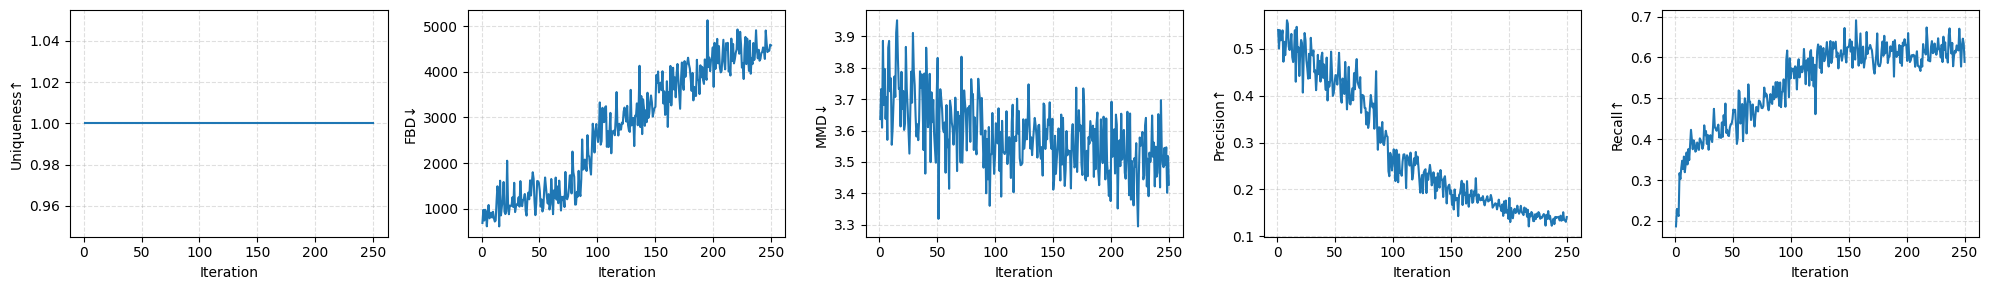

In [22]:
metrics_to_show = ["Uniqueness", "FBD", "MMD", "Precision", "Recall"]

fig, axes = plt.subplots(
    nrows=1, ncols=len(metrics_to_show), figsize=(len(metrics_to_show) * 4, 3)
)

for i, name in enumerate(metrics_to_show):
    sm.plot_line(df_all, metric=name, ax=axes[i], marker=None)
    axes[i].get_legend().remove()

fig.tight_layout()

In [ ]:
cmap = plt.get_cmap("viridis")
colors = [cmap(i / (len(df_all) - 1)) for i in range(len(df_all))]

df_flat = df_all.xs("GPT-2", level=0)

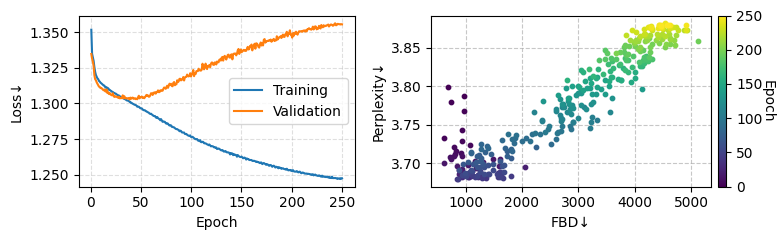

In [ ]:
fig = plt.figure(figsize=(8, 2.6))
gs = gridspec.GridSpec(1, 2, width_ratios=[0.45, 0.55])

ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])

## loss
ax = ax0

ax.plot(train_steps, train_values, label="Training")
ax.plot(val_steps, val_values, label="Validation")
ax.tick_params(axis="both", labelsize=9)
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss↓")
ax.legend()
ax.grid(True, linestyle="--", alpha=0.4)

## trade-off
ax = ax1

sm.plot_scatter(df_flat, ["FBD", "Perplexity"], marker_size=10, ax=ax, color=colors)
ax.get_legend().remove()
ax.tick_params(axis="both", labelsize=9)

norm = mpl.colors.Normalize(vmin=0, vmax=NUM_TRAIN_EPOCHS)
mappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
cbar = fig.colorbar(mappable, ax=ax, pad=0.02)
cbar.set_label("Epoch", rotation=270, va="center")
cbar.ax.tick_params(labelsize=8)

fig.tight_layout()
fig.savefig(WORKDIR_PATH / "figs/case2/both.png", bbox_inches="tight", dpi=300)

In [25]:
generated_sequences = generate(model, n_samples=10, max_length=MAX_LENGTH)

In [26]:
for seq in generated_sequences:
    print(len(seq), seq)

511 ACTGAATGGATACTGGAATACTGGATACTGGAACACTGGATACTGGATGCTGGATAGCTGGATAGTTGGATACTGGATGCTGGATGATAGCTGACAGCTGGATACTGGGAAACTGGAAACTGGGCACGGAAAAAAAAAAGAAGAAAGAAAAAAGAGAAAAAGAAAAAGGAGAAAAAAAAAAAAAAAAGAAGAAAAAAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
511 GAATTTCTTTAAATTTATGGCCCATTCCAATGGCAGTGGAGAGCGGAGGAACCGAAACGGAAGGCGTGTTTGGCTTATGGCGCCACTTGCGGCAGGCATTTTTGTGCACTCAAAATGCCACGCCCACCTTTTCAACGTGATCTTGAATTCGGCAGAGAACGCCGCACCGGAAAAGGAATGGGAAGGAAAAAAAAAAGCGCGTTCGGGAAAAAAAGAAAAAAGGAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGTTTTAAAAAAAAGCAAAAAAAAAAAAAAAAGGGCGCTTTGAAAAAAAAAAAAAAAAAAGAAAAAAAAAAAAAAAAAAAAAAAGCCAAAAAGCCCAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGCCGCCAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA